# Chapter 2 - Production Code

We begin with some imports

In [1]:
import quantecon as qe
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm           # import colormap stuff!
import matplotlib.colors as plc
from matplotlib import cm

import networkx as nx



## Multisector Models

- Figure 2.1: Backward linkages for 15 US sectors in 2019

Define IO functions.

In [2]:
def spec_rad(M):
    """
    Compute the spectral radius of M.
    """
    return np.max(np.abs(np.linalg.eigvals(M)))

def katz_centrality(A, b=1, authority=False):
    """
    Computes the Katz centrality of A, defined as the x solving

    x = 1 + b A x    (1 = vector of ones)

    Assumes that A is square.

    If authority=True, then A is replaced by its transpose.
    """
    n = len(A)
    I = np.identity(n)
    C = I - b * A.T if authority else I - b * A
    return np.linalg.solve(C, np.ones(n))


def eigenvector_centrality(A, k=40, authority=False):
    """
    Computes the dominant eigenvector of A. Assumes A is 
    primitive and uses the power method.  
    
    """
    A_temp = A.T if authority else A
    n = len(A_temp)
    r = spec_rad(A_temp)
    e = r**(-k) * (np.linalg.matrix_power(A_temp, k) @ np.ones(n))
    return e / np.sum(e)

def read_Z(data_file='data/csv_files/use_15_2019.csv', 
           N=15, 
           columnlist=['Name',
                       'Total Intermediate',
                       'Personal consumption expenditures',
                       'Private fixed investment',
                       'Change in private inventories',
                       'Exports of goods and services',
                       'Government consumption expenditures and gross investment',
                       'Total use of products']):
    """
    Build the Z matrix from the use table.
    
    * Z[i, j] = sales from sector i to sector j
    
    """
    df1 = pd.read_csv(data_file)
    df2 = df1[:N]
    if columnlist != None:
        df3 = df2.drop(columns=columnlist)
    else:
        df3 = df2
    df4 = df3.replace('...', 0)
    Z = np.asarray(df4.values.tolist(), dtype=np.float64)
    return Z

def read_X(data_file='data/csv_files/make_15_2019.csv',
           colname='Total Industry Output',
           N=15):
    """
    Read total industry sales column from the make table.

    """
    df5 = pd.read_csv(data_file)
    X = np.asarray(df5[colname])
    X = X[0:N].astype(np.float)
    return X

def build_coefficient_matrices(Z, X):
    """
    Build coefficient matrices A and F from Z and X via 
    
        A[i, j] = Z[i, j] / X[j] 
        F[i, j] = Z[i, j] / X[i]
    
    """
    A, F = np.empty_like(Z), np.empty_like(Z)
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            A[i, j] = Z[i, j] / X[j]
            F[i, j] = Z[i, j] / X[i]

    return A, F

def to_zero_one(x):
    "Map vector x to the zero one interval."
    x_min, x_max = x.min(), x.max()
    return (x - x_min)/(x_max - x_min)


Define plot graph.

In [3]:
def plot_graph(A, 
               X,
               ax,
               codes,
               node_color_list=None,
               node_size_multiple=0.0005, 
               edge_size_multiple=14,
               layout_type='circular',
               layout_seed=1234,
               tol=0.03):  # clip entries below tol

    G = nx.DiGraph()
    N = len(A)

    # Add nodes, with weights by sales of the sector
    for i, w in enumerate(X):
        G.add_node(codes[i], weight=w, name=codes[i])

    node_sizes = X * node_size_multiple

    # Position the nodes
    if layout_type == 'circular':
        node_pos_dict = nx.circular_layout(G)
    elif layout_type == 'spring':
        node_pos_dict = nx.spring_layout(G, seed=layout_seed)
    elif layout_type == 'random':
        node_pos_dict = nx.random_layout(G, seed=layout_seed)
    elif layout_type == 'spiral':
        node_pos_dict = nx.spiral_layout(G)

    # Add the edges, along with their colors and widths
    edge_colors = []
    edge_widths = []
    for i in range(N):
        for j in range(N):
            a = A[i, j]
            if a > tol:
                G.add_edge(codes[i], codes[j])
                edge_colors.append(node_color_list[i])
                width = a * edge_size_multiple
                edge_widths.append(width)
    
    nx.draw_networkx_nodes(G, 
                           node_pos_dict, 
                           node_color=node_color_list, 
                           node_size=node_sizes, 
                           edgecolors='grey', 
                           linewidths=2, 
                           alpha=0.6, 
                           ax=ax)

    nx.draw_networkx_labels(G, 
                            node_pos_dict, 
                            font_size=10, 
                            ax=ax)

    nx.draw_networkx_edges(G, 
                           node_pos_dict, 
                           edge_color=edge_colors, 
                           width=edge_widths, 
                           arrows=True, 
                           arrowsize=20, 
                           alpha=0.6,  
                           ax=ax, 
                           arrowstyle='->', 
                           node_size=node_sizes, 
                           connectionstyle='arc3,rad=0.15')

Set params.

In [4]:
codes =  ( 'ag',    
           'mi',  
           'ut',  
           'co',  
           'ma',  
           'wh',  
           're', 
           'tr',  
           'in',  
           'fi',  
           'pr', 
           'ed',   
           'ar',  
           'ot',  
           'go')

Z, X = read_Z(), read_X()

A, F = build_coefficient_matrices(Z, X)

ecentral = eigenvector_centrality(A)
ecentral_color_list = cm.plasma(to_zero_one(ecentral))

/tmp/ipykernel_9897/2792980170.py:70: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X[0:N].astype(np.float)


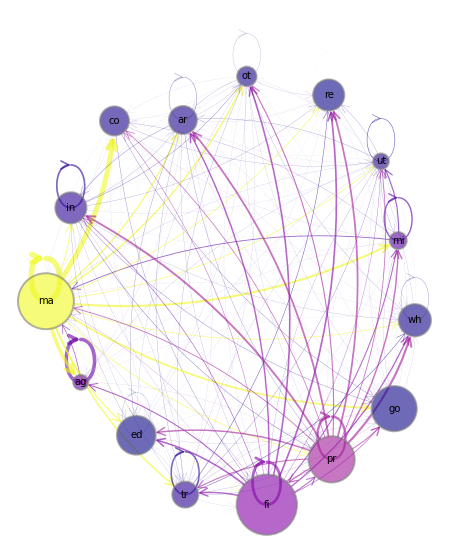

In [5]:
fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")

plot_graph(A, X, ax, codes, 
              layout_type='spring', # alternative layouts: spring, circular, random, spiral
              layout_seed=5432167,
              tol=0.0,
              node_color_list=ecentral_color_list) 

plt.show()

- Figure 2.2: Network for 71 US sectors in 2019

In [6]:
codes_71 = ('111CA',
         '113FF',
         '211',
         '212',
         '213',
         '22',
         '23',
         '321',
         '327',
         '331',
         '332',
         '333',
         '334',
         '335',
         '3361MV',
         '3364OT',
         '337',
         '339',
         '311FT',
         '313TT',
         '315AL',
         '322',
         '323',
         '324',
         '325',
         '326',
         '42',
         '441',
         '445',
         '452',
         '4A0',
         '481',
         '482',
         '483',
         '484',
         '485',
         '486',
         '487OS',
         '493',
         '511',
         '512',
         '513', 
         '514',
         '521CI',
         '523',
         '524',
         '525',
         'HS',
         'ORE',
         '532RL',
         '5411',
         '5415',
         '5412OP',
         '55',
         '561',
         '562',
         '61',
         '621',
         '622',
         '623',
         '624',
         '711AS',
         '713',
         '721',
         '722',
         '81',
         'GFGD',
         'GFGN',
         'GFE',
         'GSLG',
         'GSLE')

Z_71, X_71 = read_Z(data_file='data/csv_files/use_71_2019.csv',
                 N=71,
                 columnlist=['Unnamed: 0', 'T001', 'F010', 'F02E', 'F02N', 
                             'F02R', 'F02S', 'F030', 'F040', 'F06C', 'F06E', 
                             'F06N', 'F06S', 'F07C', 'F07E', 'F07N', 'F07S', 
                             'F10C', 'F10E', 'F10N', 'F10S', 'T019']), read_X(data_file='data/csv_files/make_71_2019.csv', N=71)

A_71, F_71 = build_coefficient_matrices(Z_71, X_71)

ecentral_71 = eigenvector_centrality(A_71)
ecentral_color_list_71 = cm.plasma(to_zero_one(ecentral_71))


/tmp/ipykernel_9897/2792980170.py:70: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X[0:N].astype(np.float)


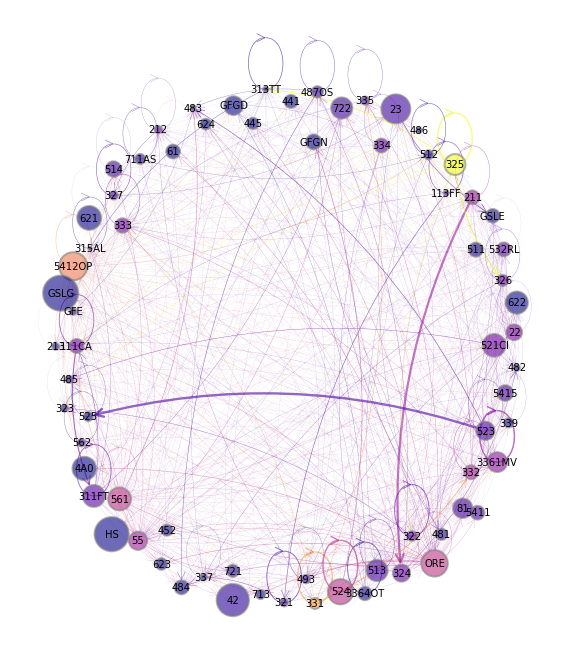

In [7]:
fig, ax = plt.subplots(figsize=(10, 12))
plt.axis("off")

plot_graph(A_71, X_71, ax, codes_71,
              node_size_multiple=0.0005,
              edge_size_multiple=4.0,
              layout_type='spring', # alternative layouts: spring, circular, random, spiral
              layout_seed=5432167,
              tol=0.01,
              node_color_list=ecentral_color_list_71)

plt.show()

- Figure 2.4: The Leontief inverse 𝐿 (hot colors are larger values)

In [8]:
def plot_matrices(matrix,
                  codes,
                  ax,
                  font_size=12,
                  alpha=0.6, 
                  colormap=cm.viridis, 
                  color45d=None, 
                  xlabel='sector $j$', 
                  ylabel='sector $i$'):
    
    ticks = range(len(matrix))

    levels = np.sqrt(np.linspace(0, 0.75, 100))
    
    
    if color45d != None:
        co = ax.contourf(ticks, 
                         ticks,
                         matrix,
#                          levels,
                         alpha=alpha, cmap=colormap)
        ax.plot(ticks, ticks, color=color45d)
    else:
        co = ax.contourf(ticks, 
                         ticks,
                         matrix,
                         levels,
                         alpha=alpha, cmap=colormap)

    #plt.colorbar(co)

    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    ax.set_yticks(ticks)
    ax.set_yticklabels(codes)
    ax.set_xticks(ticks)
    ax.set_xticklabels(codes)


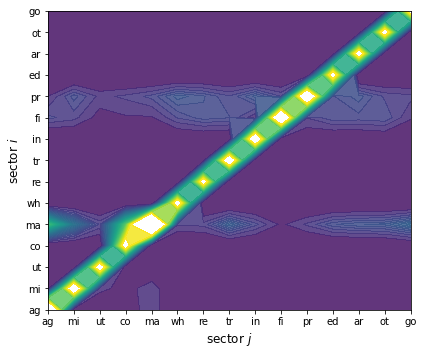

In [9]:
I = np.identity(len(A))
L = np.linalg.inv(I - A)

fig, ax = plt.subplots(figsize=(6.5, 5.5))
plot_matrices(L, codes, ax, alpha=0.85)

plt.show()


- Figure 2.5: Propagation of demand shocks via backward linkages

In [10]:
sim_length = 6
N = len(A)
d = np.random.rand(N) # np.zeros(N)
d[6] = 1  # positive shock to agriculture
x = d
x_vecs = []
for i in range(sim_length):
    x_vecs.append(x)
    x = A @ x


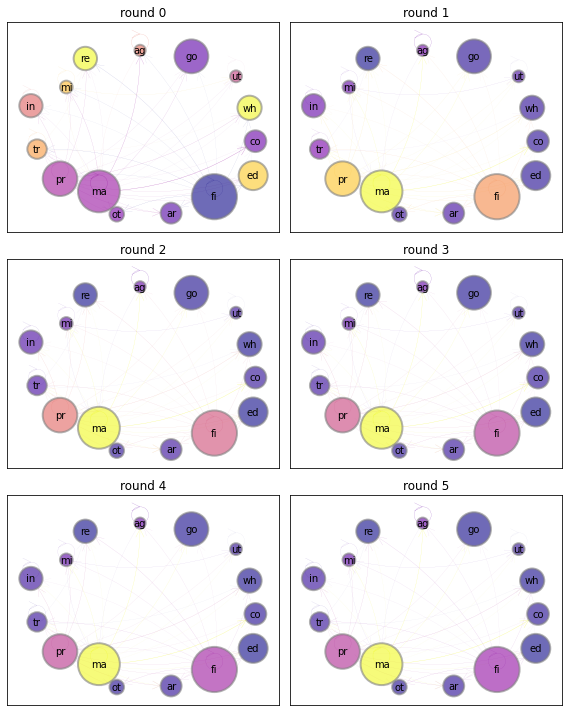

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for ax, x_vec, i in zip(axes, x_vecs, range(sim_length)):
    ax.set_title(f"round {i}")
    x_vec_cols = cm.plasma(to_zero_one(x_vec))
    plot_graph(A, X, ax, codes,
                  layout_type='spring', # alternative layouts: spring, circular, random, spiral
                  layout_seed=342156,
                  node_color_list=x_vec_cols,
                  node_size_multiple=0.00028,
                  edge_size_multiple=0.8)

plt.tight_layout()
plt.show()


- Figure 2.6: Eigenvector centrality of across US industrial sectors

In [12]:
ecentral = eigenvector_centrality(A)
ecentral_color_list = cm.plasma(to_zero_one(ecentral))

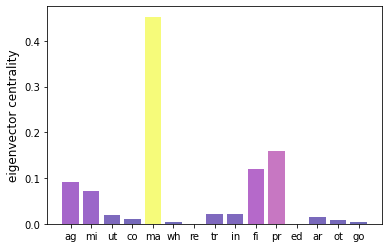

In [13]:
fig, ax = plt.subplots()
ax.bar(codes, ecentral, color=ecentral_color_list, alpha=0.6)

ax.set_ylabel("eigenvector centrality", fontsize=12)

plt.show()

- Figure 2.8: Output multipliers across 15 US industrial sectors

In [14]:
omult = katz_centrality(A, authority=True)
omult_color_list = cm.plasma(to_zero_one(omult))


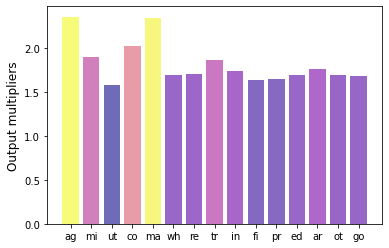

In [15]:
fig, ax = plt.subplots()
ax.bar(codes, omult, color=omult_color_list, alpha=0.6)

ax.set_ylabel("Output multipliers", fontsize=12)

plt.show()

- Figure 2.9: Forward linkages and upstreamness over US industrial sectors

In [16]:
upstreamness = katz_centrality(F)
upstreamness_color_list = cm.plasma(to_zero_one(upstreamness))


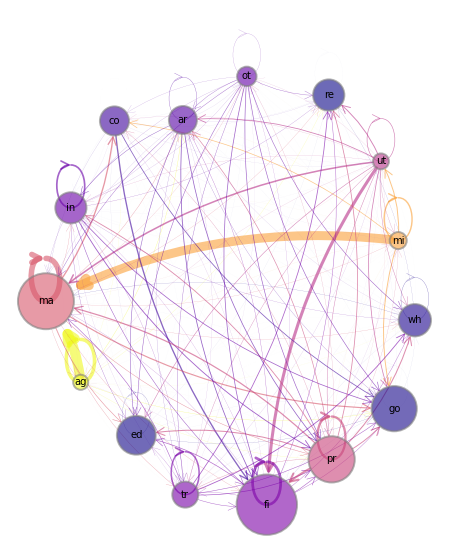

In [17]:
fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")

plot_graph(F, X, ax, codes, 
              layout_type='spring', # alternative layouts: spring, circular, random, spiral
              layout_seed=5432167,
              tol=0.0,
              node_color_list=upstreamness_color_list) 

plt.show()


- Figure 2.10: Relative upstreamness of US industrial sectors

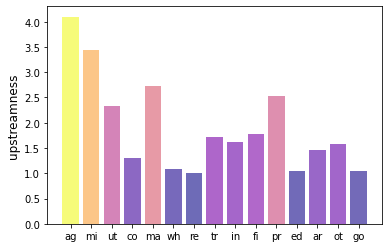

In [18]:
fig, ax = plt.subplots()
ax.bar(codes, upstreamness, color=upstreamness_color_list, alpha=0.6)

ax.set_ylabel("upstreamness", fontsize=12)

plt.show()

## General Equilibrium

- Figure 2.11: GDP growth rates and std. deviations (in parentheses) for 8 countries

**No code in repo**


- Figure 2.14: Hub-based Katz centrality of across 15 US industrial sectors

In [19]:
kcentral = katz_centrality(A)
kcentral_color_list = cm.plasma(to_zero_one(kcentral))

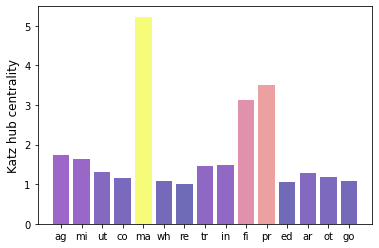

In [20]:
fig, ax = plt.subplots()
ax.bar(codes, kcentral, color=kcentral_color_list, alpha=0.6)
ax.set_ylabel("Katz hub centrality", fontsize=12)

plt.show()
